# Custom CNN for image classification
### Team: 0Idee (Bono Federico, Cecere Nicola, Zanutto Davide)

### Import libraries and set seed for reporducibility

In [14]:
import tensorflow as tf
import numpy as np
import os
import random
import splitfolders
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import seaborn as sns

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [15]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings & Split dataset

In [16]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [17]:
# Splitting the main dataset into train and val
# No test for final submission
dataset_dir = './dataset_split'

if not (os.path.exists(dataset_dir)):
    print('splitting')
    splitfolders.ratio('./training_data_final', output=dataset_dir, seed=seed, ratio=(0.8, 0.2))

# Setting dataset directories
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

### Data augmentation

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=20,
                                        horizontal_flip= True,
                                        vertical_flip= True,
                                        brightness_range=(0.6,1.4),
                                        zoom_range=0.6,
                                        fill_mode='nearest',
                                        preprocessing_function = preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None,
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

Found 2829 images belonging to 8 classes.


In [19]:
valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed
                                               )

Found 713 images belonging to 8 classes.


## Models
### Parameters and configuration

In [20]:
input_shape = (96, 96, 3)
batch_size = 32
epochs = 200
labels = ['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']

### Transfer learning

In [21]:
# Download and plot the EfficientNetV2B3 model
supernet = tfk.applications.EfficientNetV2B3(
    include_top=False,
    weights="imagenet",
    input_shape= input_shape
)
supernet.summary()

Model: "efficientnetv2-b3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 96, 96, 3)    0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 96, 96, 3)   0           ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 48, 48, 40)   1080        ['normalization_1

In [22]:
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr * tf.math.exp(-0.1)

In [23]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)

  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'),
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)

  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  # Learning Rate Scheduler --------------------------------------------
  LRS_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
  callbacks.append(LRS_callback)

  return callbacks

In [24]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
x = supernet(inputs)
# Flattening layer
# -------------------------------------------------------
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.2, seed=seed)(x)
# Dense layers
# ------------------------------------------------------
x = tfkl.Dense(
    128,
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
leaky_relu_layer = tfkl.LeakyReLU()(x)
x = tfkl.Dropout(0.2, seed=seed)(leaky_relu_layer)

outputs = tfkl.Dense(
    8,
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tfk.metrics.Precision(), tfk.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b3 (Function  (None, 3, 3, 1536)       12930622  
 al)                                                             
                                                                 
 Flattening (Flatten)        (None, 13824)             0         
                                                                 
 dropout_2 (Dropout)         (None, 13824)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1769600   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                             

In [13]:
# Train the model
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug_Pre')

tl_history = tl_model.fit(
    x = aug_train_gen,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks
).history

Epoch 1/200
18/89 [=====>........................] - ETA: 12s - loss: 2.7924 - accuracy: 0.2500 - precision: 0.2757 - recall: 0.1771

KeyboardInterrupt: 

In [ ]:
# Save the best model
tl_model.save('TransferLearningModel_LearningRate_0,8-0,2-flipped')

### Fine tuning

In [25]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel_LearningRate_0,8-0,2-flipped')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b3 (Function  (None, 3, 3, 1536)       12930622  
 al)                                                             
                                                                 
 Flattening (Flatten)        (None, 13824)             0         
                                                                 
 dropout_2 (Dropout)         (None, 13824)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1769600   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                             

In [26]:
# Set all efficientNet layers to True
ft_model.get_layer('efficientnetv2-b3').trainable = True
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-b3').layers):
   print(i, layer.name, layer.trainable)

0 input_3 True
1 rescaling_1 True
2 normalization_1 True
3 stem_conv True
4 stem_bn True
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn True
8 block1a_project_activation True
9 block1b_project_conv True
10 block1b_project_bn True
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block2a_expand_conv True
15 block2a_expand_bn True
16 block2a_expand_activation True
17 block2a_project_conv True
18 block2a_project_bn True
19 block2b_expand_conv True
20 block2b_expand_bn True
21 block2b_expand_activation True
22 block2b_project_conv True
23 block2b_project_bn True
24 block2b_drop True
25 block2b_add True
26 block2c_expand_conv True
27 block2c_expand_bn True
28 block2c_expand_activation True
29 block2c_project_conv True
30 block2c_project_bn True
31 block2c_drop True
32 block2c_add True
33 block3a_expand_conv True
34 block3a_expand_bn True
35 block3a_expand_activation True
36 block3a_project_conv True
37 block3a_project_bn True
38 block3b_

In [27]:
# Freeze first N layers
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-b3').layers[:190]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-b3').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_3 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv False
3

In [28]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tfk.metrics.Precision(), tfk.metrics.Recall()])

In [29]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = aug_train_gen,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks
).history

Epoch 1/200
89/89 [==============================] - 70s 615ms/step - loss: 1.5996 - accuracy: 0.4857 - precision_2: 0.5895 - recall_2: 0.3468 - val_loss: 1.0379 - val_accuracy: 0.6536 - val_precision_2: 0.7520 - val_recall_2: 0.5273 - lr: 0.0010
Epoch 2/200
89/89 [==============================] - 39s 441ms/step - loss: 1.1228 - accuracy: 0.5974 - precision_2: 0.7081 - recall_2: 0.4818 - val_loss: 0.8612 - val_accuracy: 0.6774 - val_precision_2: 0.7478 - val_recall_2: 0.5989 - lr: 0.0010
Epoch 3/200
30/89 [=========>....................] - ETA: 19s - loss: 1.0193 - accuracy: 0.6493 - precision_2: 0.7332 - recall_2: 0.5579

KeyboardInterrupt: 

In [71]:
ft_model.save('FineTuningModel_LearningRate_0,8-0,2-flipped')

## Results
### Confusion matrix, Accuracy, Precision and Recall

In [31]:
def get_next_batch(generator):
    return next(generator)

from sklearn.metrics import classification_report, confusion_matrix
batch = get_next_batch(valid_gen)
true_label = batch[1]
pred_label = ft_model.predict(batch[0])
for i in range(0,500):
    batch = get_next_batch(valid_gen)
    true_label = np.concatenate((true_label, batch[1]), axis=0)
    pred_label = np.concatenate((pred_label, ft_model.predict(batch[0])), axis=0)

1/1 [==============================] - 0s 128ms/step


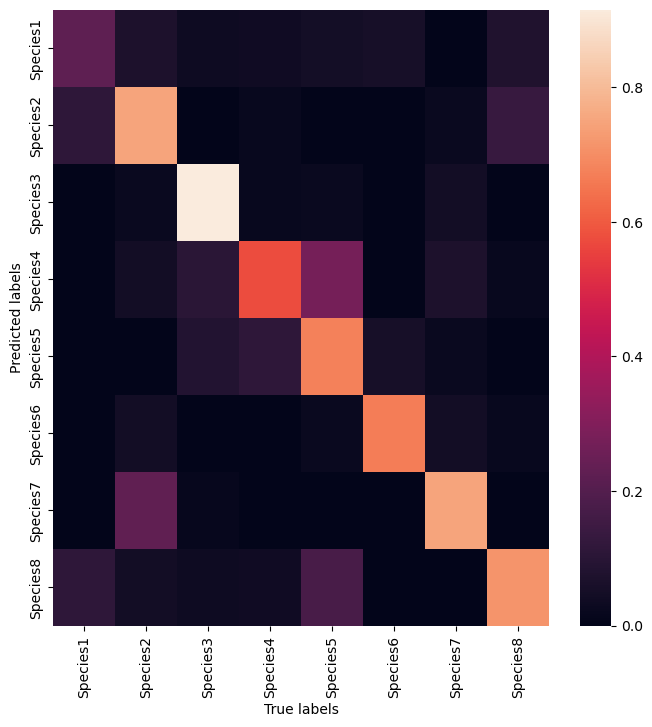

In [32]:
#confusion matrix
cm = confusion_matrix(np.argmax(true_label, axis=-1), np.argmax(pred_label, axis=-1))
# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm/sum(true_label), xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

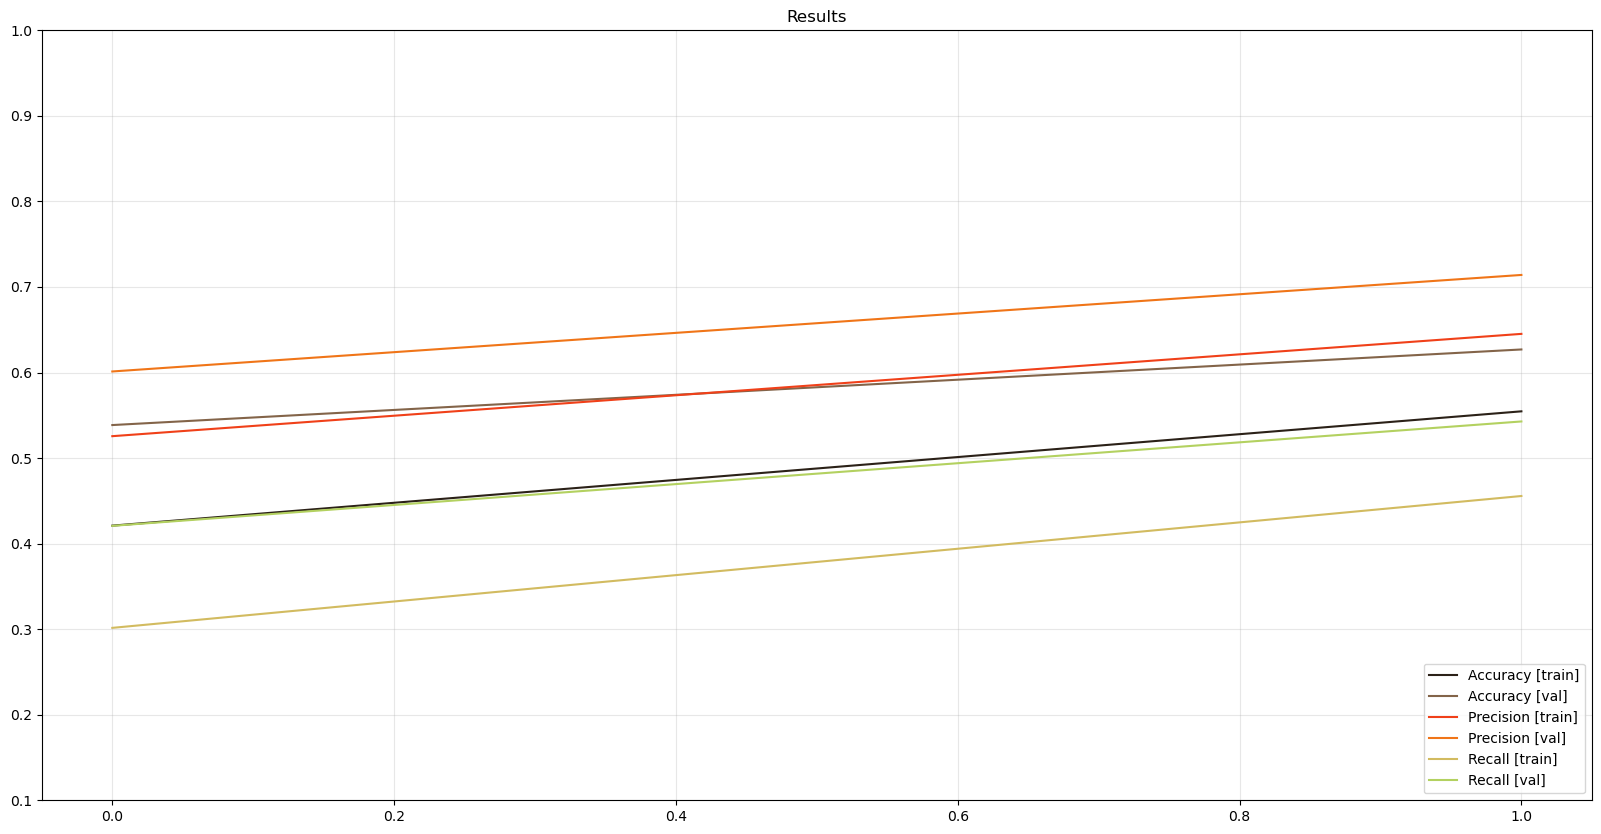

In [22]:
ALPHA = 1

plt.figure(figsize=(20,10))

plt.plot(ft_history['accuracy'], label='Accuracy [train]', alpha=ALPHA, color='#2B2118')
plt.plot(ft_history['val_accuracy'], label='Accuracy [val]', alpha=ALPHA, color='#836449')

plt.plot(ft_history['precision_1'], label='Precision [train]', alpha=ALPHA, color='#F04019')
plt.plot(ft_history['val_precision_1'], label='Precision [val]', alpha=ALPHA, color='#F07518')

plt.plot(ft_history['recall_1'], label='Recall [train]', alpha=ALPHA, color='#D2BB60')
plt.plot(ft_history['val_recall_1'], label='Recall [val]', alpha=ALPHA, color='#B3D160')

plt.ylim(0.1, 1)
plt.title('Results')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()

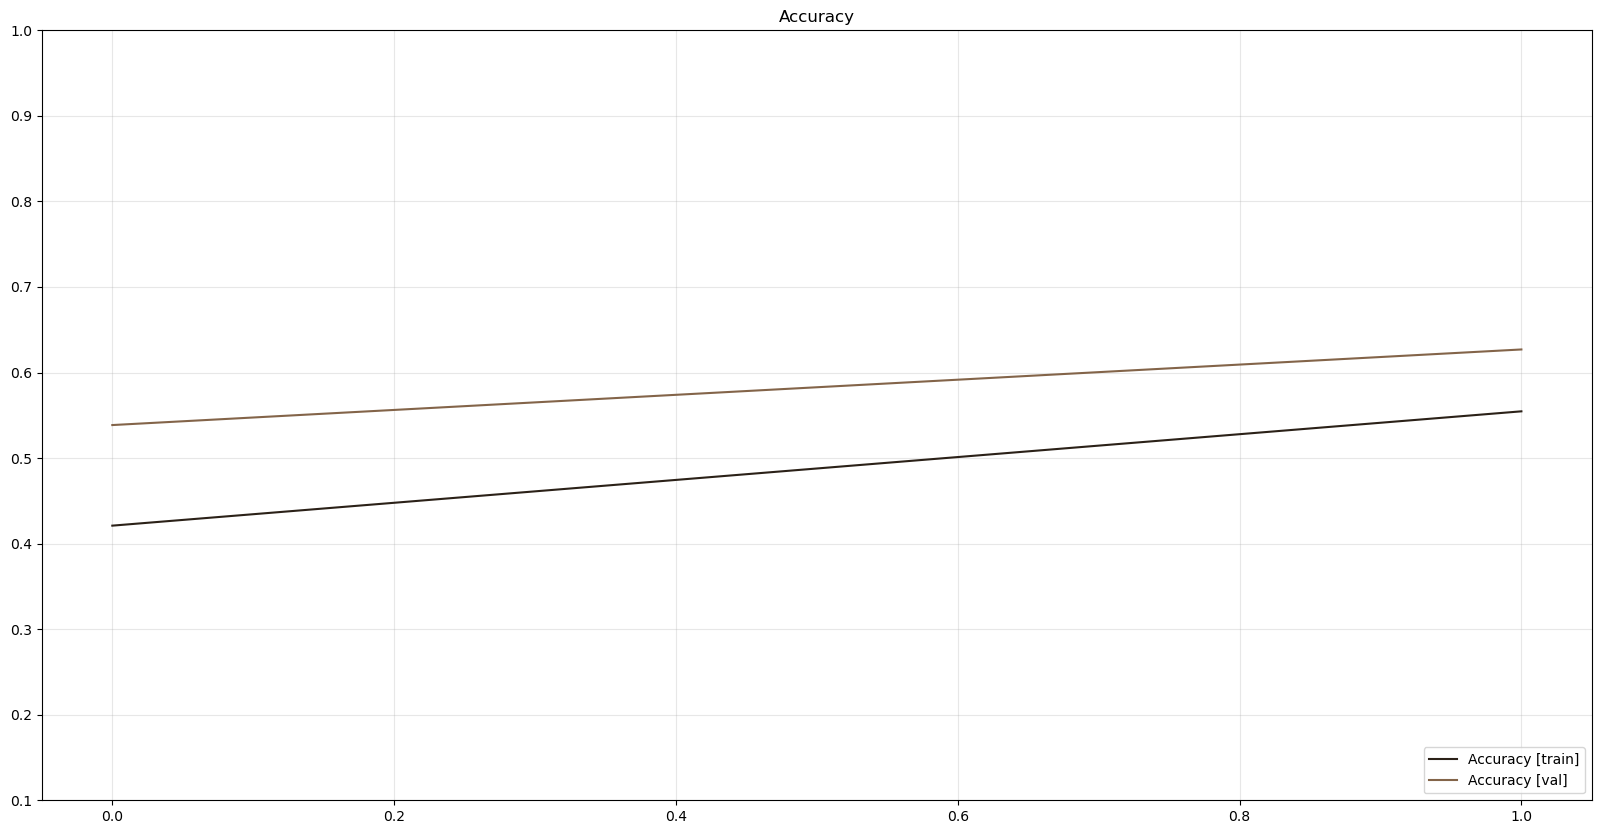

In [23]:
# Accuracy Graph
plt.figure(figsize=(20,10))

plt.plot(ft_history['accuracy'], label='Accuracy [train]', alpha=ALPHA, color='#2B2118')
plt.plot(ft_history['val_accuracy'], label='Accuracy [val]', alpha=ALPHA, color='#836449')

plt.ylim(.1, 1)
plt.title('Accuracy')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()

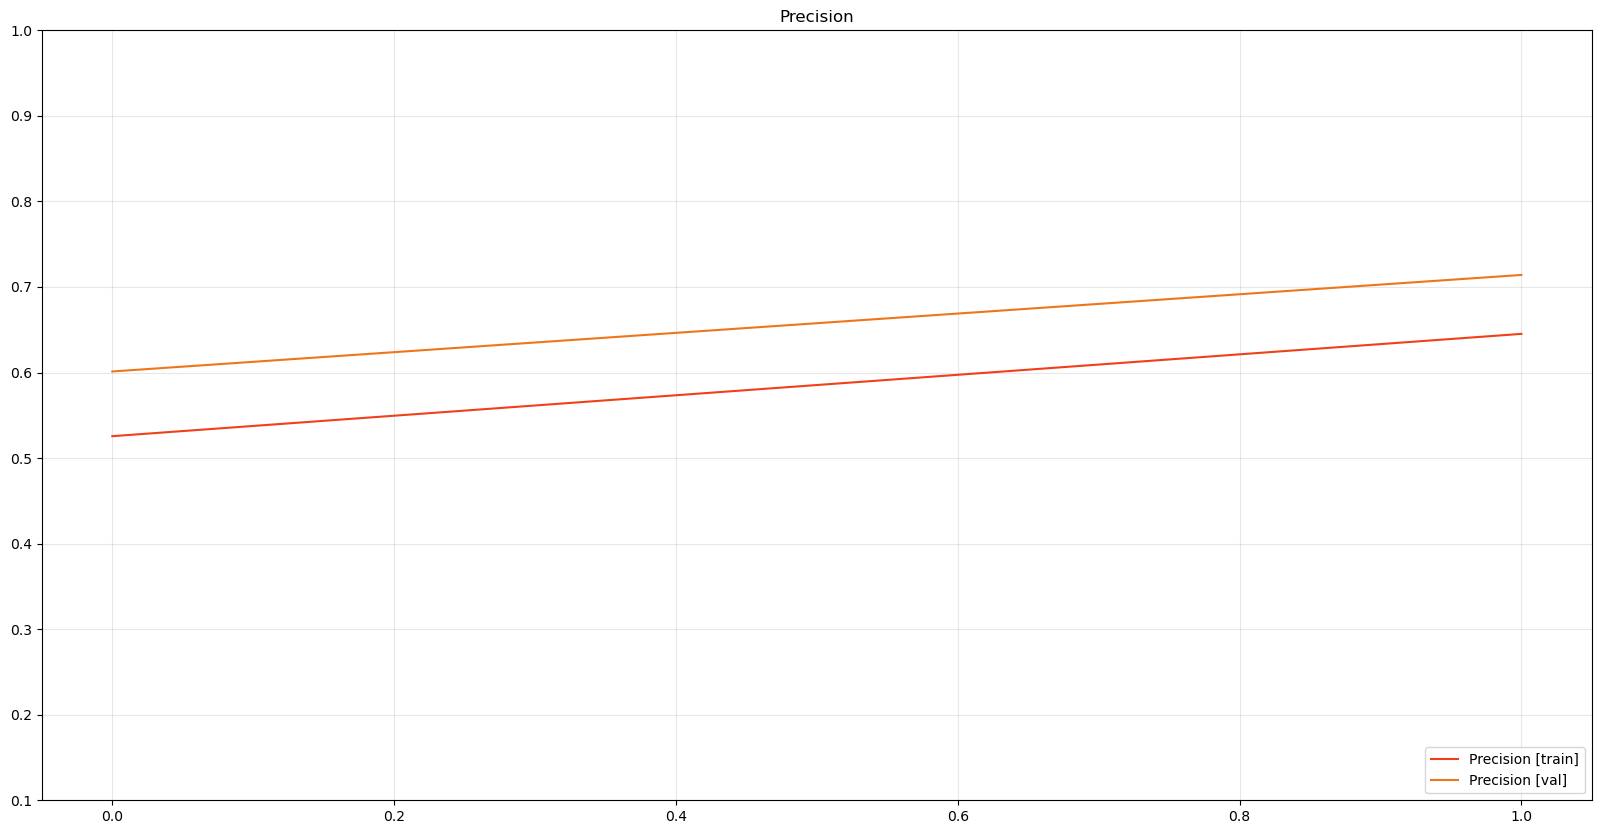

In [24]:
# Precision Graph
plt.figure(figsize=(20,10))

plt.plot(ft_history['precision_1'], label='Precision [train]', alpha=ALPHA, color='#F04019')
plt.plot(ft_history['val_precision_1'], label='Precision [val]', alpha=ALPHA, color='#F07518')

plt.ylim(.1, 1)
plt.title('Precision')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()

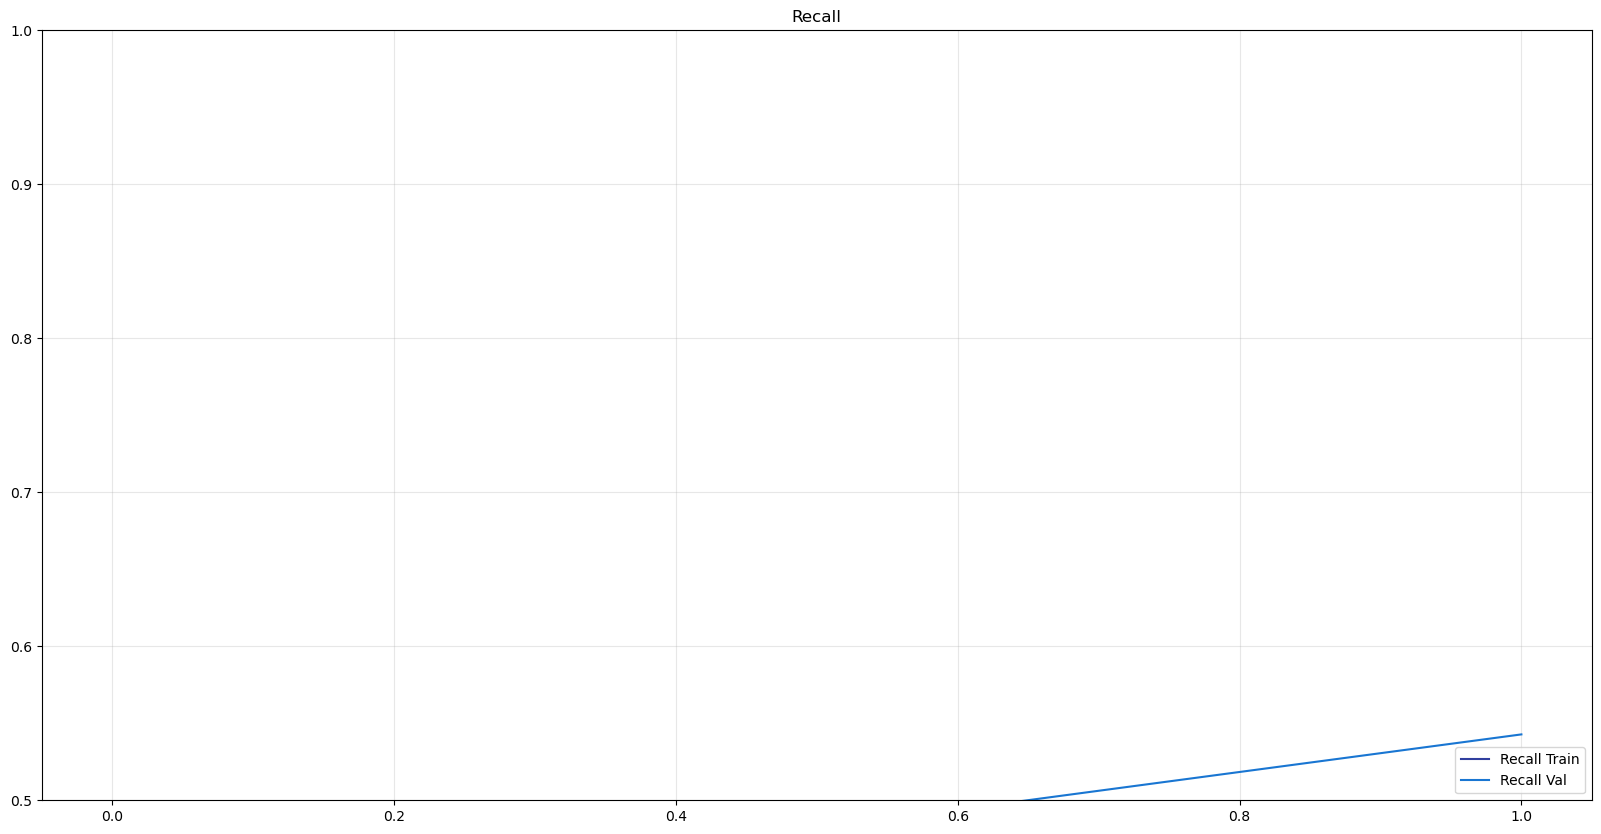

In [25]:
# Recall Graph
plt.figure(figsize=(20,10))

plt.plot(ft_history['recall_1'], label='Recall Train', alpha=ALPHA, color='#303F9F')
plt.plot(ft_history['val_recall_1'], label='Recall Val', alpha=ALPHA, color='#1976D2')

plt.ylim(.5, 1)
plt.title('Recall')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()

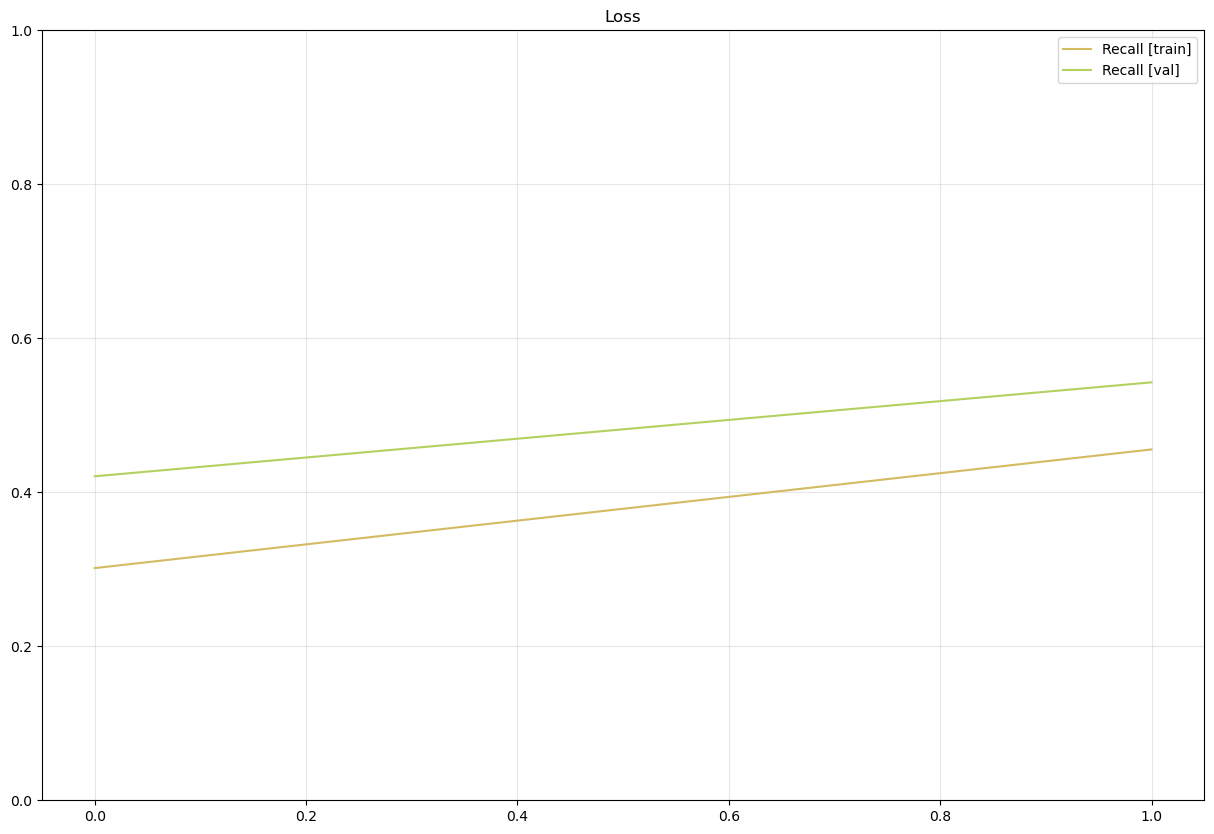

In [26]:
# Loss Graph
plt.figure(figsize=(15,10))

plt.plot(ft_history['recall_1'], label='Recall [train]', alpha=ALPHA, color='#D2BB60')
plt.plot(ft_history['val_recall_1'], label='Recall [val]', alpha=ALPHA, color='#B3D160')

plt.ylim(0, 1)
plt.title('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()